In [1]:
import ee
service_account = 'renosterveld-ee@ee-vegetation-gee4geo.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, 'ee-vegetation-gee4geo-6309a79ef209.json')
ee.Initialize(credentials,project='ee-vegetation-gee4geo')

In [ ]:
import tensorflow as tf
import json
from eoflow.models import TransformerEncoder, TempCNNModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from utils.tf_data_utils import *
from utils.globals import *

tf.random.set_seed(42)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
with open('data/max.json') as f:
  Max = json.load(f)

with open('data/min.json') as f:
  Min = json.load(f)

In [5]:
trainFilePath = 'data/Training_reno_cnn.tfrecord.gz'
testFilePath = 'data/Testing_reno_cnn.tfrecord.gz'
validFilePath = 'data/Valid_reno_cnn.tfrecord.gz'

In [6]:
# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[tsLength], dtype=tf.float32) 
    for k in featureNames
]
# Dictionary with names as keys, features as values.
featuresDict = dict(zip(featureNames, columns))

# plot time

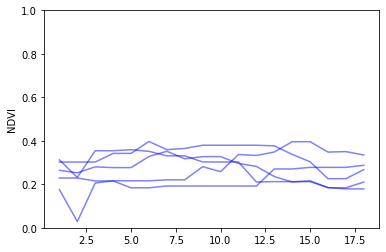

In [7]:
dataset0 = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3,len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(lambda x: filter_fn(x,[0.0]))\

y = iter(dataset0.shuffle(buffer_size=100000, seed=42).batch(5)).next()
y = y['ndvi'].numpy().transpose()
x = np.arange(1, 19, 1)

plt.plot(x, y,color='blue',alpha=0.5)
plt.ylabel('NDVI')
plt.ylim(0,1)
plt.show()

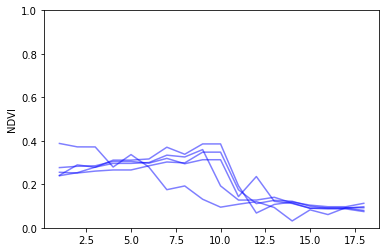

In [8]:
dataset1 = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3,len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(lambda x: filter_fn(x,[1.0]))\

y = iter(dataset1.shuffle(buffer_size=100000, seed=42).batch(5)).next()
y = y['ndvi'].numpy().transpose()
x = np.arange(1, 19, 1)

plt.plot(x, y,color='blue',alpha=0.5)
plt.ylabel('NDVI')
plt.ylim(0,1)
plt.show()

# data

In [7]:
dataset = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3, len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(lambda x: filter_fn(x,[0.0,1.0]))\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.shuffle(buffer_size=buff, seed=42)\
.repeat()\
.batch(batch_size)

In [8]:
valDataset = tf.data.TFRecordDataset(validFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3, len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(lambda x: filter_fn(x,[0.0,1.0]))\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(batch_size)

## CNN

In [ ]:
#model pars
model_cfg = {
    "learning_rate": lr,
    "n_classes": n_classes,
    "keep_prob": 0.8,
    "metrics": ["accuracy","precision","recall"],
    "loss": "focal_loss",
    "kernel_regularizer": 1e-08,
    "nb_conv_filters": 32,
    "nb_conv_stacks": 6
}

# rubn model
model_cnn = TempCNNModel(model_cfg)
model_cnn.build(input_shape)
model_cnn.prepare()
model_cnn.train_and_evaluate(
    train_dataset=dataset,
    val_dataset=valDataset,
    num_epochs=epochs,
    iterations_per_epoch=steps,
    model_directory=model_cnn_directory,
    save_steps='epoch',
    summary_steps='epoch',
    verbose=1
)

In [ ]:
model_cnn.load_weights(checkpoints_cnn_path)
#result = model_cnn.evaluate(valDataset,verbose=1,return_dict=True)

In [10]:
model_cnn.save('models/saved_cnn_model_cpu')
#model_cnn = tf.keras.models.load_model('models/saved_cnn_model_cpu', compile=False)

## Transformer

In [ ]:
#model pars
model_cfg = {
    "learning_rate": lr/10,
    "n_classes": n_classes,
    "keep_prob": 0.5,
    "metrics": ["accuracy","precision","recall"],
    "loss": "focal_loss",
    "num_heads": 4,
    "num_layers": 4,
    "d_model": 128,
    "layer_norm": False,
    "num_dff":256
}

# rubn model
model_trans = TransformerEncoder(model_cfg)
model_trans.build(input_shape)
model_trans.prepare()
model_trans.train_and_evaluate(
    train_dataset=dataset,
    val_dataset=valDataset,
    num_epochs=epochs,
    iterations_per_epoch=steps,
    model_directory=model_tran_directory,
    save_steps='epoch',
    summary_steps='epoch',
    verbose=1
)

In [ ]:
model_trans.load_weights(checkpoints_tran_path)
#result = model_trans.evaluate(valDataset,verbose=1,return_dict=True)

In [ ]:
model_trans.save('models/saved_trans_model_cpu')
#model_trans = tf.keras.models.load_model('models/saved_trans_model_cpu', compile=False)

## Random Forest

In [59]:
dataset = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3, len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn)\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(1)

valDataset = tf.data.TFRecordDataset(validFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, WINDOW/3, len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn)\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(1)

tlab = list(dataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator())
trainy=list(tlab)

tdat = list(dataset\
.map(lambda x,lab: x)\
.as_numpy_iterator())
trainx=list(tdat)

vallab = list(valDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator())
valy=list(vallab)

valdat = list(valDataset\
.map(lambda x,lab: x)\
.as_numpy_iterator())
valx=list(valdat)

labelval = np.vstack(valy)
labelval = np.argmax(labelval,axis=1)

xval = np.vstack(valx)
xval = np.transpose(xval, (0, 2, 1))
xval_flat = xval.reshape(xval.shape[0],(xval.shape[1]*xval.shape[2]))

labeltr = np.vstack(trainy)
labeltr = np.argmax(labeltr,axis=1)

xtr = np.vstack(trainx)
xtr = np.transpose(xtr, (0, 2, 1))
xtr_flat = xtr.reshape(xtr.shape[0],(xtr.shape[1]*xtr.shape[2]))

rf_data = (xtr_flat,labeltr,xval_flat,labelval)

model_rf = RandomForestClassifier(n_estimators = 100, max_features = 'auto', min_samples_split = 4, random_state = 42)
model_rf.fit(rf_data[0], rf_data[1])
y_pred = model_rf.predict(rf_data[2])
#result = metrics.f1_score(rf_data[3],y_pred)

In [ ]:
print('f1: ', metrics.f1_score(rf_data[3],y_pred),'\n','recall: ',metrics.recall_score(rf_data[3],y_pred,average=None),'\n','precision: ',metrics.precision_score(rf_data[3],y_pred,average=None))

# Test data

In [11]:
# List of fixed-length features, all of which are float32.
testcolumns = [
  tf.io.FixedLenFeature(shape=[testLength], dtype=tf.float32) 
    for k in testNames
]
# Dictionary with names as keys, features as values.
testfeaturesDict = dict(zip(testNames, testcolumns))

In [12]:
shortDataset = tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,testfeaturesDict))\
.map(roller)\
.flat_map(lambda x: shift_window(x, 1, len(testNames)+1))\
.map(lambda x: reshape_ts(x, testNames,['lablag']))\
.map(lambda x: labeller(x, label))\
.map(lambda x: labeller(x, 'lablag'))\
.filter(lambda x: filter_fn(x,[1.0]))\
.filter(lambda x: filter_fn(x,[11.0,21.0,1.0],'lablag'))\
.map(lambda x: popkey(x,['ndvi_diff','roll','count','lablag']))\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(batch_size)

In [13]:
testDataset = tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,testfeaturesDict))\
.flat_map(lambda x: shift_window(x, 1, len(testNames)))\
.map(lambda x: reshape_ts(x, testNames))\
.map(lambda x: labeller(x, label))\
.filter(lambda x: filter_fn(x,[1.0,0.0]))\
.map(lambda x: popkey(x,['ndvi_diff','roll','count']))\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(batch_size)

## CNN test

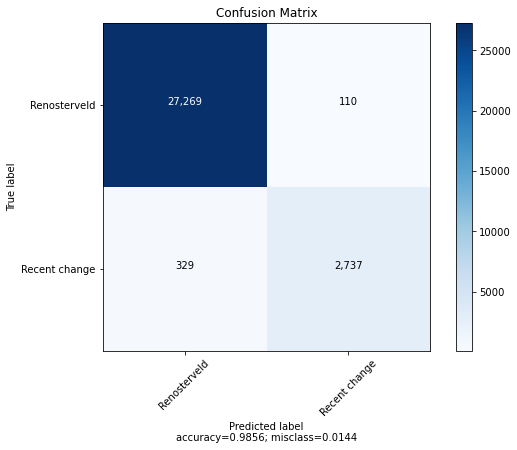

In [20]:
predictions = model_cnn.predict(testDataset)
pred_y = np.argmax(predictions,axis=1)

y_obs = testDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

y_obs = list(y_obs)

y_obs = np.vstack(y_obs)
y_obs = np.argmax(y_obs,axis=1)

con_mat = tf.math.confusion_matrix(labels=y_obs, predictions=pred_y).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")

In [15]:
print('f1: ', metrics.f1_score(y_obs,pred_y),'\n','recall: ',metrics.recall_score(y_obs,pred_y,average=None),'\n','precision: ',metrics.precision_score(y_obs,pred_y,average=None))

f1:  0.9257568070353458 
 recall:  [0.99598232 0.89269406] 
 precision:  [0.98807885 0.96136284]


#### short time frame

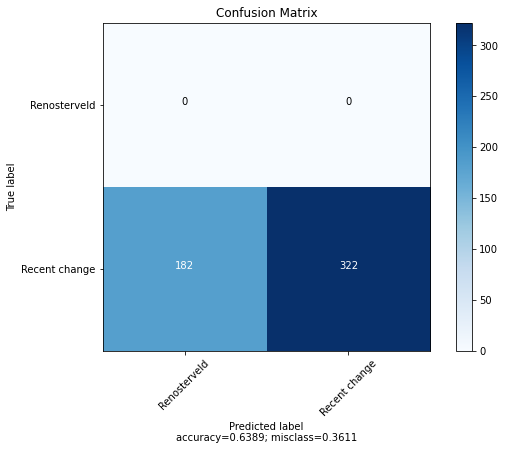

In [30]:
predictions = model_cnn.predict(shortDataset)
pred_y = np.argmax(predictions,axis=1)

y_obs = shortDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

y_obs = list(y_obs)

y_obs = np.vstack(y_obs)
y_obs = np.argmax(y_obs,axis=1)

con_mat = tf.math.confusion_matrix(labels=y_obs, predictions=pred_y).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")

In [31]:
print('f1: ', metrics.f1_score(y_obs,pred_y),'\n','recall: ',metrics.recall_score(y_obs,pred_y,average=None),'\n','precision: ',metrics.precision_score(y_obs,pred_y,average=None))

f1:  0.7796610169491525 
 recall:  [0.         0.63888889] 
 precision:  [0. 1.]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Tran test

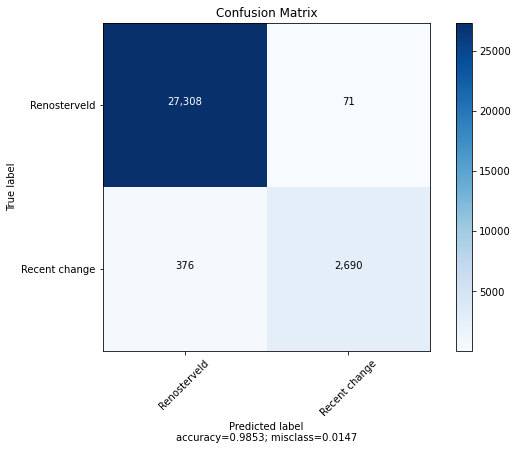

In [32]:
predictions = model_trans.predict(testDataset)
pred_y = np.argmax(predictions,axis=1)

y_obs = testDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

y_obs = list(y_obs)

y_obs = np.vstack(y_obs)
y_obs = np.argmax(y_obs,axis=1)

con_mat = tf.math.confusion_matrix(labels=y_obs, predictions=pred_y).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")

In [33]:
print('f1: ', metrics.f1_score(y_obs,pred_y),'\n','recall: ',metrics.recall_score(y_obs,pred_y,average=None),'\n','precision: ',metrics.precision_score(y_obs,pred_y,average=None))

f1:  0.9232881414106745 
 recall:  [0.99740677 0.87736464] 
 precision:  [0.98641815 0.97428468]


#### short time frame

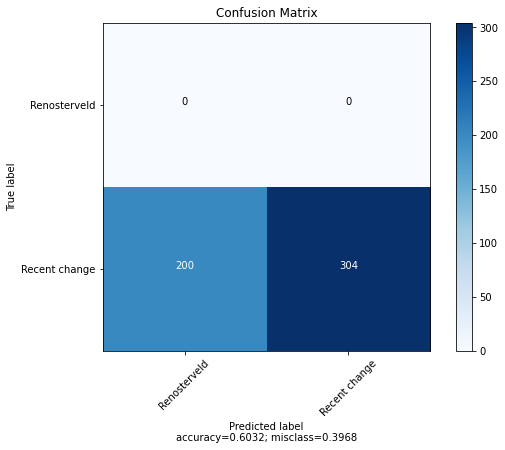

In [34]:
predictions = model_trans.predict(shortDataset)
pred_y = np.argmax(predictions,axis=1)

y_obs = shortDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

y_obs = list(y_obs)

y_obs = np.vstack(y_obs)
y_obs = np.argmax(y_obs,axis=1)

con_mat = tf.math.confusion_matrix(labels=y_obs, predictions=pred_y).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")

In [35]:
print('f1: ', metrics.f1_score(y_obs,pred_y),'\n','recall: ',metrics.recall_score(y_obs,pred_y,average=None),'\n','precision: ',metrics.precision_score(y_obs,pred_y,average=None))

f1:  0.7524752475247524 
 recall:  [0.        0.6031746] 
 precision:  [0. 1.]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CCDC test

In [66]:
pred_y =  tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,testfeaturesDict))\
.flat_map(lambda x: shift_window(x, 1, len(testNames)))\
.map(lambda x: reshape_ts(x, testNames))\
.map(lambda x: labeller(x, label))\
.map(lambda x: labeller(x, 'roll'))\
.filter(filter_fn)\
.map(lambda x: poplabint(x, 'roll'))\
.batch(batch_size)\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

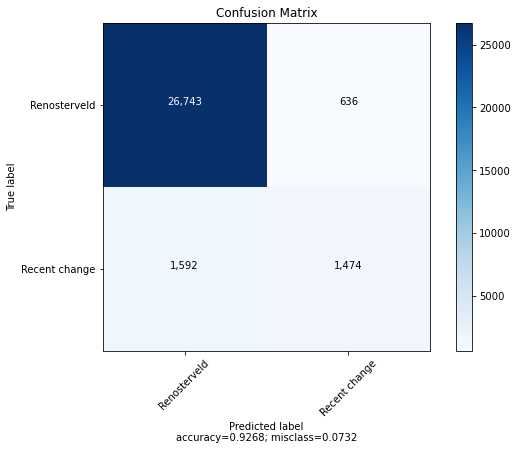

In [67]:
pred_y = list(pred_y)
pred_y = np.vstack(pred_y)

y_obs = testDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator()

y_obs = list(y_obs)

y_obs = np.vstack(y_obs)
y_obs = np.argmax(y_obs,axis=1)

con_mat = tf.math.confusion_matrix(labels=y_obs, predictions=pred_y).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")

In [68]:
print('f1: ', metrics.f1_score(y_obs,pred_y),'\n','recall: ',metrics.recall_score(y_obs,pred_y,average=None),'\n','precision: ',metrics.precision_score(y_obs,pred_y,average=None))

f1:  0.5695517774343122 
 recall:  [0.97677052 0.48075669] 
 precision:  [0.94381507 0.6985782 ]


## RF test

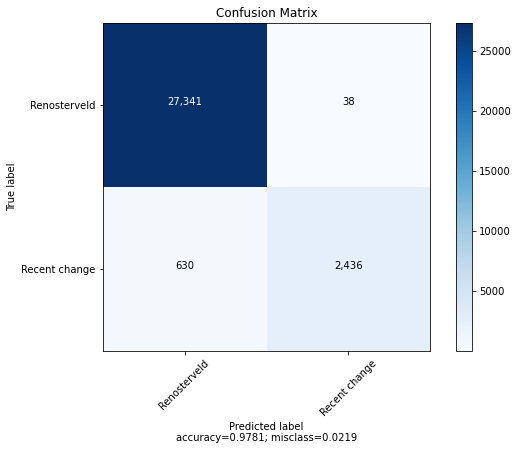

In [60]:
testDataset = tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,testfeaturesDict))\
.flat_map(lambda x: shift_window(x, 1, len(testNames)))\
.map(lambda x: reshape_ts(x, testNames))\
.map(lambda x: labeller(x, label))\
.filter(filter_fn)\
.map(lambda x: popkey(x,['ndvi_diff','roll','count']))\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(1)

vallab = list(testDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator())
valy=list(vallab)

valdat = list(testDataset\
.map(lambda x,lab: x)\
.as_numpy_iterator())
valx=list(valdat)

labelval = np.vstack(valy)
labelval = np.argmax(labelval,axis=1)

xval = np.vstack(valx)
xval = np.transpose(xval, (0, 2, 1))
xval_flat = xval.reshape(xval.shape[0],(xval.shape[1]*xval.shape[2]))

rf_data = (xval_flat,labelval)

y_pred = model_rf.predict(rf_data[0])
con_mat = tf.math.confusion_matrix(labels=rf_data[1], predictions=y_pred).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")

In [61]:
print('f1: ', metrics.f1_score(rf_data[1],y_pred),'\n','recall: ',metrics.recall_score(rf_data[1],y_pred,average=None),'\n','precision: ',metrics.precision_score(rf_data[1],y_pred,average=None))

f1:  0.87942238267148 
 recall:  [0.99861207 0.79452055] 
 precision:  [0.97747667 0.98464026]


#### short time frame

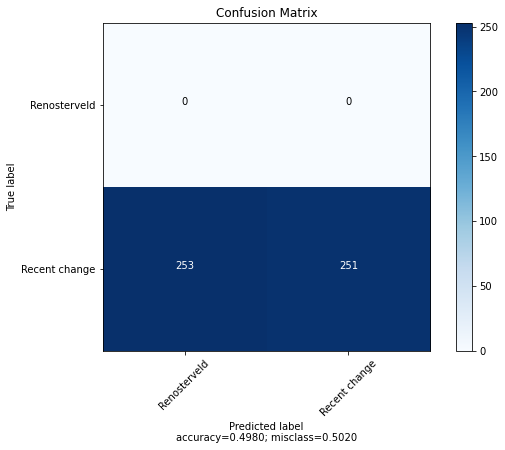

In [69]:
shortDataset = tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,testfeaturesDict))\
.map(roller)\
.flat_map(lambda x: shift_window(x, 1, len(testNames)+1))\
.map(lambda x: reshape_ts(x, testNames,['lablag']))\
.map(lambda x: labeller(x, label))\
.map(lambda x: labeller(x, 'lablag'))\
.filter(lambda x: filter_fn(x,[1.0]))\
.filter(lambda x: filter_fn(x,[11.0,21.0,1.0],'lablag'))\
.map(lambda x: popkey(x,['ndvi_diff','roll','count','lablag']))\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(1)

vallab = list(shortDataset\
.map(lambda x,lab: lab)\
.as_numpy_iterator())
valy=list(vallab)

valdat = list(shortDataset\
.map(lambda x,lab: x)\
.as_numpy_iterator())
valx=list(valdat)

labelval = np.vstack(valy)
labelval = np.argmax(labelval,axis=1)

xval = np.vstack(valx)
xval = np.transpose(xval, (0, 2, 1))
xval_flat = xval.reshape(xval.shape[0],(xval.shape[1]*xval.shape[2]))

rf_data = (xval_flat,labelval)

y_pred = model_rf.predict(rf_data[0])
con_mat = tf.math.confusion_matrix(labels=rf_data[1], predictions=y_pred).numpy()

plot_confusion_matrix(cm = con_mat, 
                      normalize    = False,
                      target_names = ['Renosterveld', 'Recent change'],
                      title        = "Confusion Matrix")

In [70]:
print('f1: ', metrics.f1_score(rf_data[1],y_pred),'\n','recall: ',metrics.recall_score(rf_data[1],y_pred,average=None),'\n','precision: ',metrics.precision_score(rf_data[1],y_pred,average=None))

f1:  0.6649006622516557 
 recall:  [0.         0.49801587] 
 precision:  [0. 1.]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
